In [1]:
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
import math
import matplotlib.pyplot as plt
import pandas as pd
import string
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from collections import Counter
import seaborn as sns
sns.set(style = "whitegrid")
import numpy as np
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
from google.colab import files
uploaded = files.upload()

Saving 2018.csv to 2018.csv
Saving 2019.csv to 2019.csv
Saving 2020.csv to 2020.csv
Saving 2021.csv to 2021.csv
Saving 2022.csv to 2022.csv


In [3]:
df_2018 = pd.read_csv('2018.csv')
df_2019 = pd.read_csv('2019.csv')
df_2020 = pd.read_csv('2020.csv')
df_2021 = pd.read_csv('2021.csv')
df_2022 = pd.read_csv('2022.csv')

In [4]:
df_2018['tweet'].head()

0    @Ben757677 @vincent13031925 Thanks Tesla owner...
1    @Grimezsz Turns out if you take Dayquil, you e...
2    Excited to have Larry Ellison &amp; Kathleen W...
3                              @NutmegTheRed @Tesla Ok
4           @westcoastbill Tesla team did a great job!
Name: tweet, dtype: object

In [5]:
# create a stopwords list
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# create a list of punctuation (english & chinese)
!pip install zhon
import string
from zhon.hanzi import punctuation
punctuation_en = string.punctuation
punctuation_cn = punctuation
punctuationlist = list(set(punctuation_en).union(punctuation_cn))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 4.1 MB/s 
  Created wheel for zhon: filename=zhon-1.1.5-py3-none-any.whl size=84321 sha256=440bbae66f674288f6b2774374c48ff794f5aa57dce77475c7bd8f476b7a9ba2
  Stored in directory: /root/.cache/pip/wheels/c1/6a/5d/4cea6c295942b528462738b5c1bd96d7fddef29834eab57617
Successfully built zhon


Create a function to filter each document:

In [8]:
def get_filter_doc(df):
  list_tweet = list(df['tweet'].str.lower())
  total_word = []
  for value in list_tweet:
    # delete URLs, '@' + user name, '&amp', '...' and numbers
    value = re.sub(r'http\S+', ' ', value).strip()
    value = re.sub('@\w+',' ',value).strip()
    value = re.sub('&amp', ' ', value).strip()
    value = re.sub('\d+(\.\d+)?', ' ', value).strip()
    value = re.sub('\.\.\.', ' ', value).strip()
      
    # word tokenize and delete the stopwords
    wordlist = list(word_tokenize(value))
    wordlist = [w for w in wordlist if not w in stop_words]
    total_word = wordlist + total_word

  # lemmatizer
  total_word = [lemmatizer.lemmatize(k) for k in total_word]
    
  # delete punctuation
  for i in punctuationlist:
    total_word = [x.replace(i,'') for x in total_word]

  total_word = [ele for ele in total_word if (ele != '') and (ele != ' ')]
  return total_word

In [9]:
word_2018 = get_filter_doc(df_2018)
word_2019 = get_filter_doc(df_2019)
word_2020 = get_filter_doc(df_2020)
word_2021 = get_filter_doc(df_2021)
word_2022 = get_filter_doc(df_2022)

Then get a set of all words.

In [10]:
total = set(word_2018 + word_2019 + word_2020 + word_2021 + word_2022)

We want a way to count term frequency (TF), so let's make dictionaries for each document. We'll initiate each dictionary first.

In [11]:
wordDict18 = dict.fromkeys(total, 0) 
wordDict19 = dict.fromkeys(total, 0) 
wordDict20 = dict.fromkeys(total, 0) 
wordDict21 = dict.fromkeys(total, 0) 
wordDict22 = dict.fromkeys(total, 0) 

Then create a function to loop through each document and add counts.

In [12]:
def wordDict(wordDict,word_year):
    for x in word_year:
        wordDict[x] += 1
    return wordDict

In [13]:
wordDict18 = wordDict(wordDict18,word_2018)
wordDict19 = wordDict(wordDict19,word_2019)
wordDict20 = wordDict(wordDict20,word_2020)
wordDict21 = wordDict(wordDict21,word_2021)
wordDict22 = wordDict(wordDict22,word_2022)

In [14]:
# review the results in a dataframe
pd.DataFrame([wordDict18, wordDict19, wordDict20, wordDict21, wordDict22])

,icu,upstream,flapsfins,precautionary,rallied,⚡️loona⚡️,literally,ipso,singled,australia,...,visibility,jolly,harassed,manner,axegrinding,owning,anti,jar,reorg,promised
0,0,0,0,0,1,1,17,0,0,1,...,0,0,1,1,0,0,0,1,1,1
1,0,1,1,2,1,1,33,1,0,10,...,1,1,1,1,1,1,0,4,1,2
2,5,1,1,2,1,1,42,2,1,12,...,1,1,1,1,1,1,0,4,1,3
3,0,0,0,1,0,0,19,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,2,0,0,2,...,0,0,0,0,0,0,2,0,0,0


# 1. Compute TF for each year

Create a function to compute TF:
1. Divide each count by the total words in the sentence
2. Turn this into a function so we can reuse it more easily

In [15]:
def compute_TF(wordDict,word_year):
    dict_TF = dict.fromkeys(wordDict.keys())
    count = len(word_year)
    for word in wordDict:
        dict_TF[word] = wordDict[word]/float(count)
    return dict_TF

In [16]:
TF2018 = compute_TF(wordDict18,word_2018)
TF2019 = compute_TF(wordDict19,word_2019)
TF2020 = compute_TF(wordDict20,word_2020)
TF2021 = compute_TF(wordDict21,word_2021)
TF2022 = compute_TF(wordDict22,word_2022)

In [17]:
# review the results in dataframe
pd.DataFrame([TF2018, TF2019, TF2020, TF2021, TF2022])

,icu,upstream,flapsfins,precautionary,rallied,⚡️loona⚡️,literally,ipso,singled,australia,...,visibility,jolly,harassed,manner,axegrinding,owning,anti,jar,reorg,promised
0,0.000000,0.000000,0.000000,0.000000,0.000054,0.000054,0.000923,0.000000,0.000000,0.000054,...,0.000000,0.000000,0.000054,0.000054,0.000000,0.000000,0.000000,0.000054,0.000054,0.000054
1,0.000000,0.000016,0.000016,0.000032,0.000016,0.000016,0.000533,0.000016,0.000000,0.000161,...,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000000,0.000065,0.000016,0.000032
2,0.000059,0.000012,0.000012,0.000024,0.000012,0.000012,0.000499,0.000024,0.000012,0.000143,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000000,0.000048,0.000012,0.000036
3,0.000000,0.000000,0.000000,0.000051,0.000000,0.000000,0.000976,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000051
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000378,0.000000,0.000000,0.000378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000378,0.000000,0.000000,0.000000


# 2. Top 10 words for each year

In [18]:
# 2018
TF2018_wf = Counter(wordDict18).most_common()
TF2018_wf[:10]

[('tesla', 289),
 ('car', 175),
 ('yes', 108),
 ('good', 101),
 ('model', 100),
 ('like', 96),
 ('year', 83),
 ('make', 78),
 ('would', 77),
 ('people', 74)]

In [19]:
# 2019
TF2019_wf = Counter(wordDict19).most_common()
TF2019_wf[:10]

[('tesla', 838),
 ('car', 481),
 ('yes', 393),
 ('model', 376),
 ('good', 359),
 ('like', 320),
 ('year', 287),
 ('would', 285),
 ('time', 267),
 ('s', 253)]

In [20]:
# 2020
TF2020_wf = Counter(wordDict20).most_common()
TF2020_wf[:10]

[('tesla', 1047),
 ('yes', 554),
 ('car', 550),
 ('good', 472),
 ('model', 406),
 ('like', 399),
 ('year', 388),
 ('would', 381),
 ('great', 370),
 ('time', 345)]

In [21]:
# 2021
TF2021_wf = Counter(wordDict21).most_common()
TF2021_wf[:10]

[('tesla', 213),
 ('good', 104),
 ('year', 104),
 ('car', 103),
 ('great', 102),
 ('time', 102),
 ('🤣🤣', 94),
 ('much', 93),
 ('would', 89),
 ('like', 89)]

In [22]:
# 2022
TF2022_wf = Counter(wordDict22).most_common()
TF2022_wf[:10]

[('tesla', 62),
 ('🤣', 46),
 ('car', 42),
 ('people', 34),
 ('would', 32),
 ('yes', 32),
 ('one', 30),
 ('good', 28),
 ('starlink', 28),
 ('time', 28)]

# 3. Histogram of word frequencies
Show the top 20 words.

<BarContainer object of 20 artists>

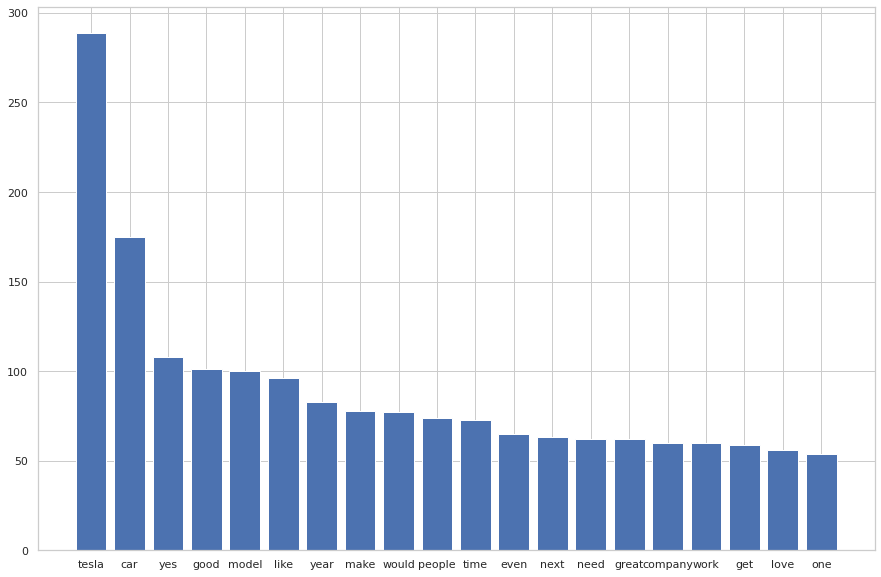

In [25]:
# 2018
plt.figure(figsize = (15,10))
plt.bar(pd.DataFrame(TF2018_wf)[0][:20], pd.DataFrame(TF2018_wf)[1][:20])

<BarContainer object of 20 artists>

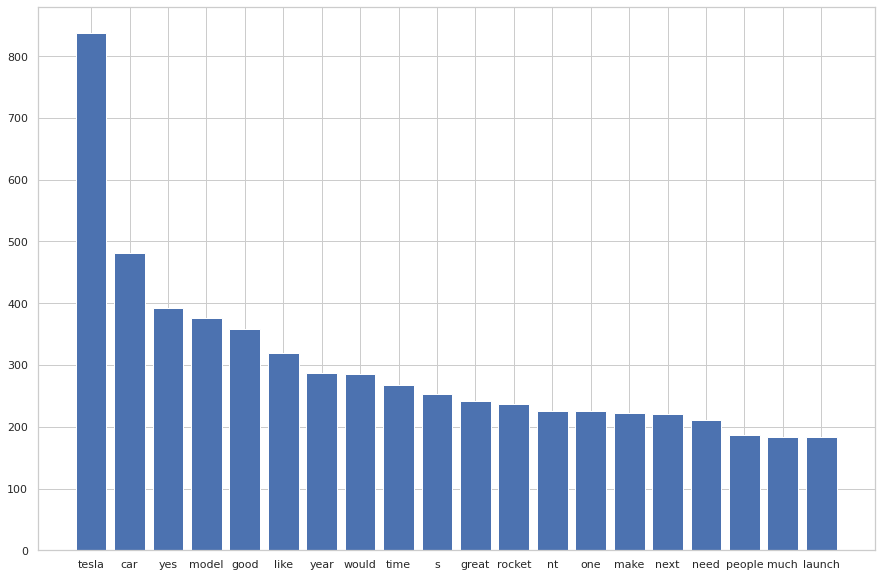

In [26]:
# 2019
plt.figure(figsize = (15,10))
plt.bar(pd.DataFrame(TF2019_wf)[0][:20], pd.DataFrame(TF2019_wf)[1][:20])

<BarContainer object of 20 artists>

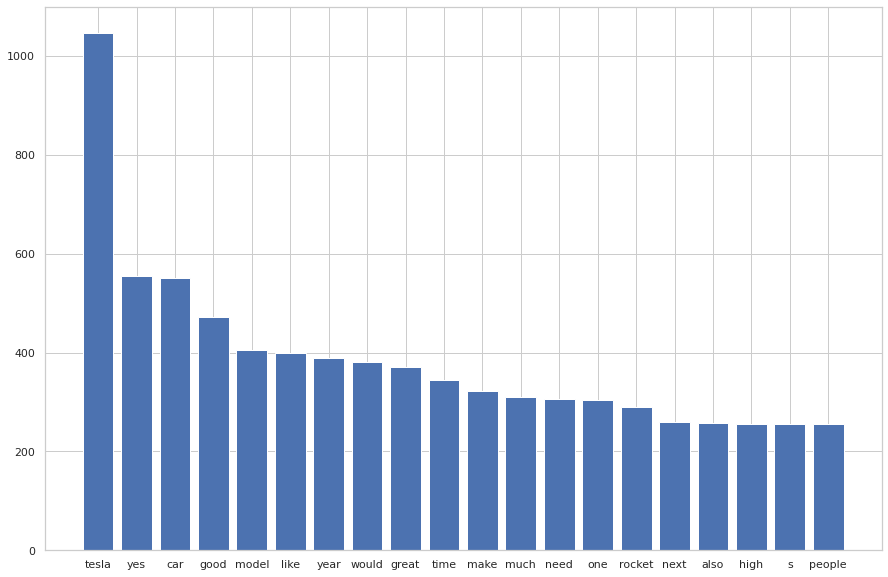

In [27]:
# 2020
plt.figure(figsize = (15,10))
plt.bar(pd.DataFrame(TF2020_wf)[0][:20], pd.DataFrame(TF2020_wf)[1][:20])

<BarContainer object of 20 artists>

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0, flags=flags)


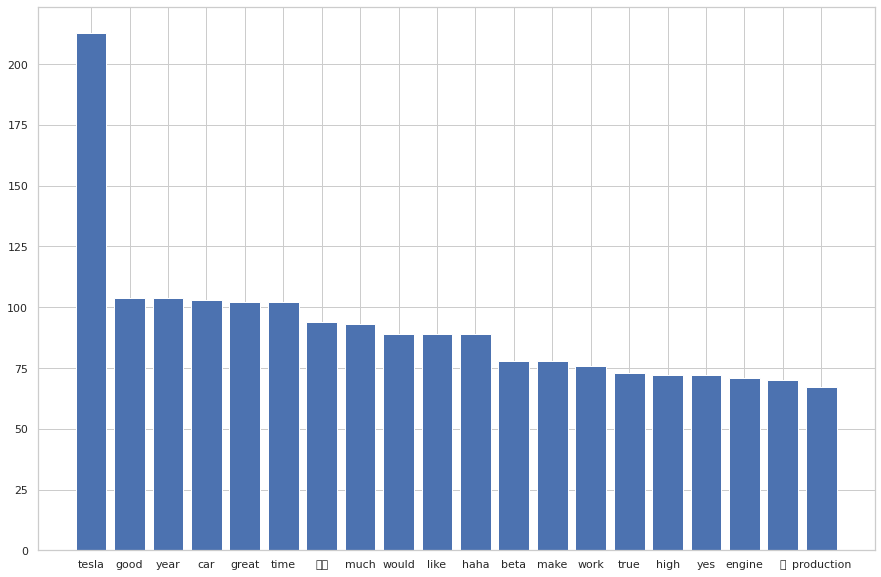

In [28]:
# 2021
plt.figure(figsize = (15,10))
plt.bar(pd.DataFrame(TF2021_wf)[0][:20], pd.DataFrame(TF2021_wf)[1][:20])

<BarContainer object of 20 artists>

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128175 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128175 missing from current font.
  font.set_text(s, 0, flags=flags)


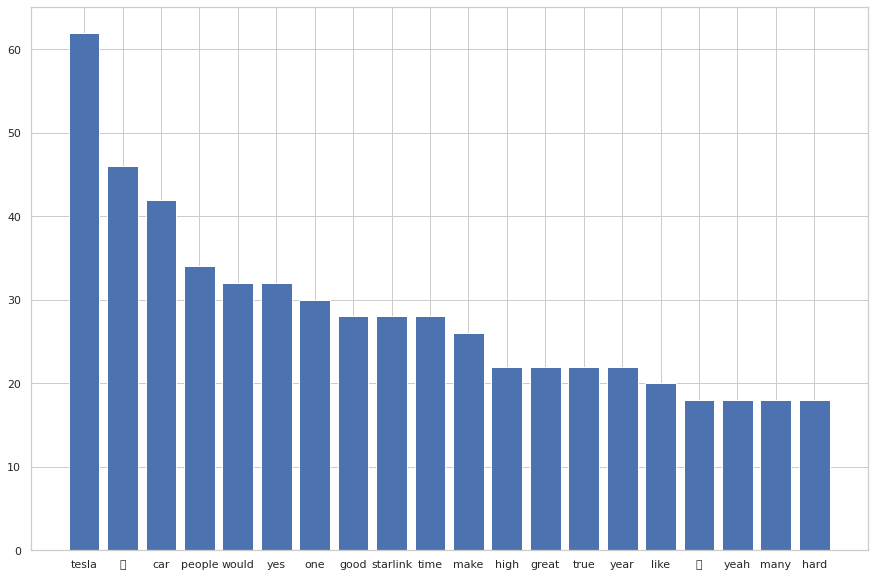

In [29]:
# 2022
plt.figure(figsize = (15,10))
plt.bar(pd.DataFrame(TF2022_wf)[0][:20], pd.DataFrame(TF2022_wf)[1][:20])

# 4. Zipf’s law

Create a function to calculate the rank and frequency and plot the graph for each year.

In [54]:
def plotzipfs(document):
  document = Counter(document).most_common()
  df = pd.DataFrame(document).reset_index()
  df['index'] = df['index'] + 1
  df['frequency'] = 1/df['index']
  plt.figure(figsize = (8,8))
  plt.plot(np.log(df['index']), np.log(df['frequency']), color = 'green', label = 'slope = -1')
  plt.plot(np.log(df['index']), np.log(df[1]/len(df)), color = 'blue', label = 'rank vs frequency')
  plt.xlabel('log(Rank)')
  plt.ylabel('log(Frequency)')
  plt.legend()
  plt.show()

2018:


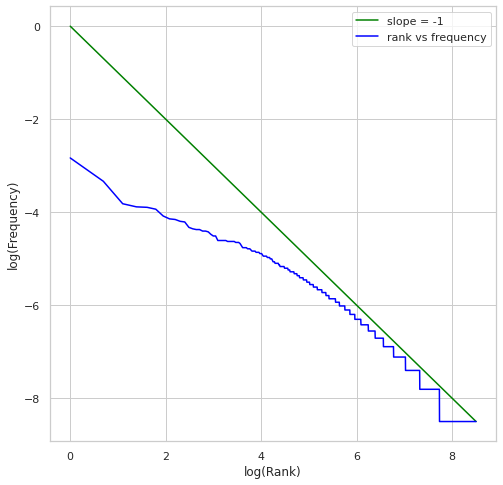

In [55]:
print('2018:')
plotzipfs(word_2018)

2019:


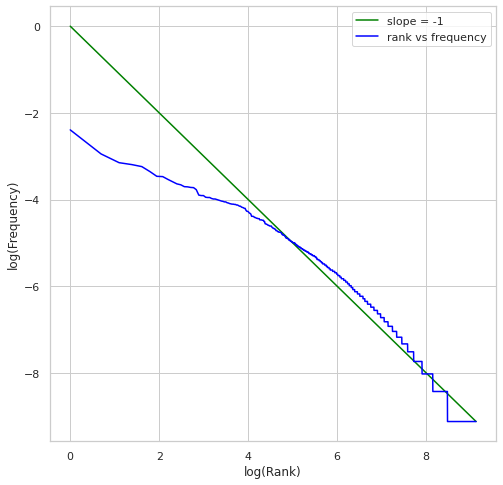

In [56]:
print('2019:')
plotzipfs(word_2019)

2020:


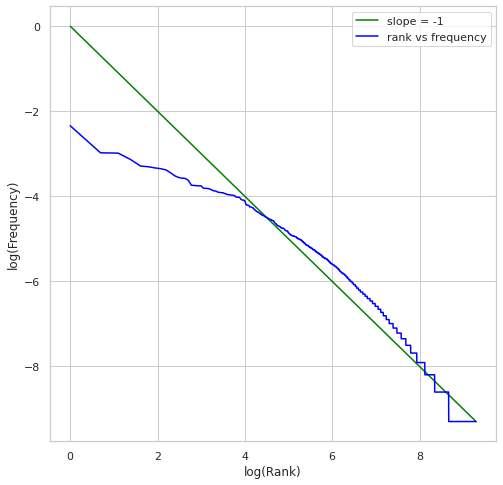

In [57]:
print('2020:')
plotzipfs(word_2020)

2021:


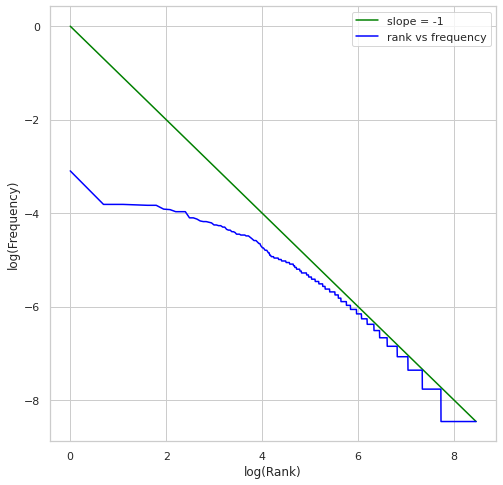

In [58]:
print('2021:')
plotzipfs(word_2021)

2022:


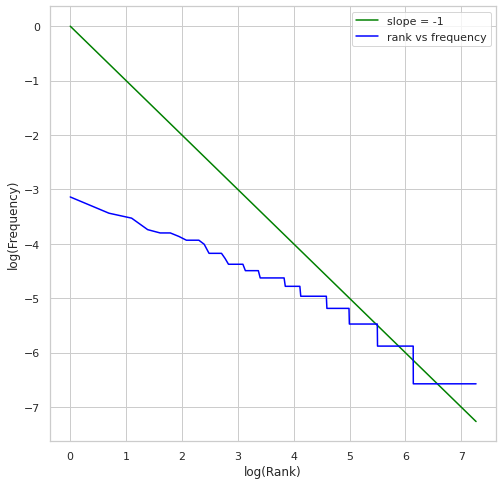

In [59]:
print('2022:')
plotzipfs(word_2022)

Plot log(rank) on the x-axis and log(frequency) on the y axis.  
If Zipf's law holds we should see a line with slope -1.  
According to the graphs above, we can find that the log-log plots have a scope nearly equal to -1 which allows the Zipf's law.

# 5. TF-IDF to find the top 5 important words for each year 

Create a function to calculate IDF.

In [46]:
def compute_IDF(doclist):
    N = len(doclist)
    dictidf = {}
    dictdf = dict.fromkeys(doclist[0].keys(),0)
    for key in dictdf:
        for doc in doclist:
            if doc[key]>0:
                dictdf[key]+=1
    for key,value in dictdf.items():
        dictidf[key] = math.log10((N + 1)/ (float(value) + 1))
    return dictidf

In [47]:
IDF = compute_IDF([wordDict18,wordDict19,wordDict20,wordDict21,wordDict22])

Then create a function to compute TF-IDF.

In [48]:
def compute_tfidf(idf,tf):
    tfidf={}
    for key,value in idf.items():
        tfidf[key] = value*tf[key]
    return tfidf 

In [49]:
# 2018
tfidf_18 = compute_tfidf(IDF, TF2018)
top5words_18 = Counter(tfidf_18).most_common()[:5]
display(top5words_18)

[('w', 0.00022943486521912867),
 ('flamethrower', 0.00019119572101594054),
 ('really', 0.00016764758935164864),
 ('dual', 0.0001338370047111584),
 ('cost', 0.00013325834025387456)]

In [50]:
# 2019
tfidf_19 = compute_tfidf(IDF,TF2019)
top5words_19 = Counter(tfidf_19).most_common()[:5]
display(top5words_19)

[('nt', 0.0006426480726445105),
 ('s', 0.0003234966774868243),
 ('w', 0.0002331731944993357),
 ('really', 0.00016366630323444073),
 ('space', 0.00014576530131817377)]

In [51]:
# 2020
tfidf_20= compute_tfidf(IDF,TF2020)
top5words_20 = Counter(tfidf_20).most_common()[:5]
display(top5words_20)

[('nt', 0.00047282931014036334),
 ('s', 0.00023989470626426424),
 ('ventilator', 0.0001984060726316512),
 ('sn', 0.00018411052784226536),
 ('w', 0.00017155753730756544)]

In [52]:
# 2021
tfidf_21= compute_tfidf(IDF,TF2021)
top5words_21 = Counter(tfidf_21).most_common()[:5]
display(top5words_21)

[('doge', 0.0008039009744518808),
 ('🤣🤣', 0.0003822430735659785),
 ('doo', 0.0003675441054229117),
 ('starbase', 0.00029373304835741797),
 ('ship', 0.00019518795245922305)]

In [53]:
# 2022
tfidf_22= compute_tfidf(IDF,TF2022)
top5words_22 = Counter(tfidf_22).most_common()[:5]
display(top5words_22)

[('💯', 0.0005991763068057207),
 ('tonga', 0.0005411583229334545),
 ('vaccination', 0.00036077221528896974),
 ('extraordinary', 0.00036077221528896974),
 ('manganese', 0.00036077221528896974)]